### Кейс №2 - Приложение доставки

Вы работаете аналитиком в приложении по доставке продуктов. Команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

Ваша задача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

Результат вашей работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему рекомендаций на всех пользователей.

In [162]:
import pandas as pd 
import numpy as np

import scipy.stats as ss
import pingouin as pg

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [94]:
df_user_data = pd.read_csv('ab_users_data.csv')
df_order = pd.read_csv('ab_orders.csv')
df_products = pd.read_csv('ab_products.csv')

## Предварительное изучение данных

### df_user_data 
Данные: 
- user_id - id пользователя
- order_id - id заказа
- action - действие ('create_order', 'cancel_order')
- time - время совершения действия
- date - дата
- group - группа (0 - контрольная, 1 - экспериментальная)

In [95]:
df_user_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


In [96]:
df_user_data.action.unique()

array(['create_order', 'cancel_order'], dtype=object)

In [97]:
df_user_data.dtypes

user_id      int64
order_id     int64
action      object
time        object
date        object
group        int64
dtype: object

In [98]:
df_user_data['time'] = pd.to_datetime(df_user_data['time'])
df_user_data['date'] = pd.to_datetime(df_user_data['date'], format='%Y-%m-%d')

In [99]:
df_user_data.shape

(4337, 6)

In [100]:
df_user_data.groupby('group')\
    .agg({'order_id':'count'})

,order_id
group,
0,1691
1,2646


In [101]:
df_user_data.user_id.nunique()

1017

In [102]:
df_user_data.order_id.nunique()

4123

### df_order  

Данные:
- order_id - id заказа
- creation_time - время создания заказа
- product_ids - список продуктов 

In [103]:
df_order.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [104]:
df_order.shape

(4123, 3)

In [105]:
df_order.order_id.nunique()

4123

In [106]:
df_order.dtypes

order_id          int64
creation_time    object
product_ids      object
dtype: object

In [107]:
df_order['creation_time'] = pd.to_datetime(df_order['creation_time'])

### df_products  
Данные:
- product_id - id продукта
- name - наименование
- price - цена за единицу товара

In [108]:
df_products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [109]:
df_products.shape

(87, 3)

In [110]:
df_products.product_id.nunique()

87

In [111]:
df_products.price.agg(['min', 'max'])

min      1.0
max    800.0
Name: price, dtype: float64

### Выводы (предварительный анализ): 
1. В датасете df_user_data есть отмененные заказы, которые нужно учесть при анализе
2. df_order.creation_time == df_user_data.time при df_user_data.action == create_order
3. 

## Метрики и гипотезы
*Метрики:*
- количество товаров в заказе 
- сумма заказа

Гиротезы:  
$H_0$ - Средние значения количества продуктов в заказах равны в контрольной и экспериментальной группах  
$H_1$ - Средние значения количества продуктов в заказах не равны в контрольной и экспериментальной группах

$H_0$ - Средние значения стоимости заказов равны в контрольной и экспериментальной группах  
$H_1$ - Средние значения стоимости заказов не равны в контрольной и экспериментальной группах$$
$$

## Найдем необходимые метрики

In [112]:
# перевод айдишников продуктов в список  
def list_product_ids(x):
    x = x[1:-1]
    id_product = list(map(int, x.split(',')))
    return id_product

In [113]:
# подсчет суммы покупки
def purchase_amount(x):
    result = 0
    for item in x:
        result += df_products.iloc[df_products.query(f'product_id == {item}').index[0]]['price']
    return result

In [114]:
df_order["product_ids"] = df_order.product_ids.apply(list_product_ids)

In [115]:
df_order['count_product'] = df_order.product_ids.apply(lambda x: len(x))

In [117]:
df_order['purchase_amount'] = df_order.product_ids.apply(purchase_amount)

In [118]:
df_order.head()

,order_id,creation_time,product_ids,count_product,purchase_amount
0,1255,2022-08-26 00:00:19,"[75, 22, 53, 84]",4,408.7
1,1256,2022-08-26 00:02:21,"[56, 76, 39]",3,250.5
2,1257,2022-08-26 00:02:27,"[76, 34, 41, 38]",4,310.2
3,1258,2022-08-26 00:02:56,"[74, 6]",2,85.0
4,1259,2022-08-26 00:03:37,"[20, 45, 67, 26]",4,228.0


In [120]:
df_user_data.head()
#cancel_order

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1


### Формирование общего датасета 
Необходимо исключить заказы, которые отменили

In [129]:
cancel_order_list = list(df_user_data.order_id[df_user_data.action == 'cancel_order'])

In [135]:
df_user_no_cancel_order = df_user_data[~ df_user_data.order_id.isin(cancel_order_list)]

In [138]:
df = df_user_no_cancel_order.merge(df_order, how='inner', on='order_id')

In [139]:
df.head()

,user_id,order_id,action,time,date,group,creation_time,product_ids,count_product,purchase_amount
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,"[75, 22, 53, 84]",4,408.7
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,2022-08-26 00:02:21,"[56, 76, 39]",3,250.5
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0,2022-08-26 00:02:27,"[76, 34, 41, 38]",4,310.2
3,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1,2022-08-26 00:03:37,"[20, 45, 67, 26]",4,228.0
4,968,1261,create_order,2022-08-26 00:05:35,2022-08-26,0,2022-08-26 00:05:35,"[30, 35, 69, 6]",4,430.7


### Графики

Text(0, 0.5, 'Сумма заказа')

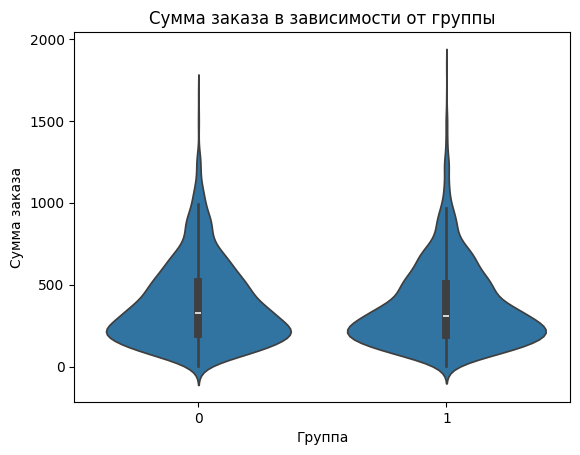

In [146]:
sns.violinplot(x = 'group', y = 'purchase_amount', data = df)
plt.title('Сумма заказа в зависимости от группы')
plt.xlabel('Группа')
plt.ylabel('Сумма заказа')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, '2022-08-26'),
  Text(1, 0, '2022-08-27'),
  Text(2, 0, '2022-08-28'),
  Text(3, 0, '2022-08-29'),
  Text(4, 0, '2022-08-30'),
  Text(5, 0, '2022-08-31'),
  Text(6, 0, '2022-09-01'),
  Text(7, 0, '2022-09-02'),
  Text(8, 0, '2022-09-03'),
  Text(9, 0, '2022-09-04'),
  Text(10, 0, '2022-09-05'),
  Text(11, 0, '2022-09-06'),
  Text(12, 0, '2022-09-07'),
  Text(13, 0, '2022-09-08')])

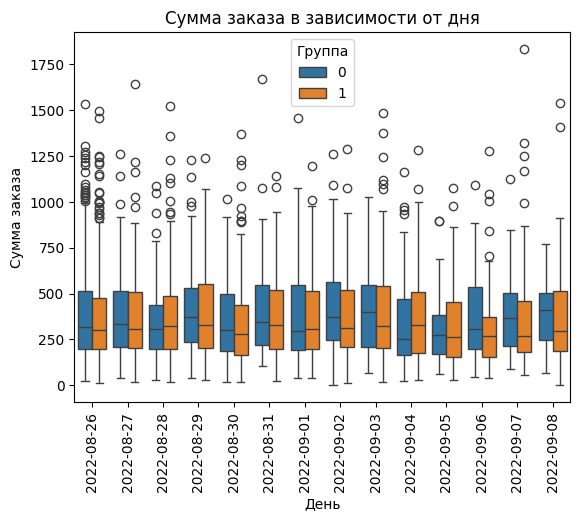

In [152]:
sns.boxplot(x = 'date', y = 'purchase_amount', hue = 'group', data = df)
plt.title('Сумма заказа в зависимости от дня')
plt.xlabel('День')
plt.ylabel('Сумма заказа')
plt.legend(title = 'Группа')
plt.xticks(rotation=90)

Text(0, 0.5, 'Количество товаров')

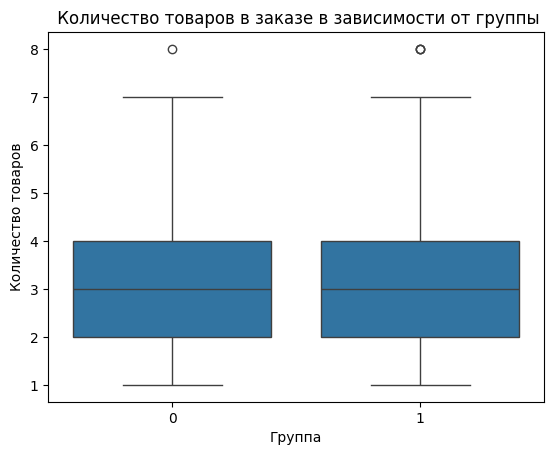

In [149]:
sns.boxplot(x = 'group', y = 'count_product', data = df)
plt.title(' Количество товаров в заказе в зависимости от группы')
plt.xlabel('Группа')
plt.ylabel('Количество товаров')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, '2022-08-26'),
  Text(1, 0, '2022-08-27'),
  Text(2, 0, '2022-08-28'),
  Text(3, 0, '2022-08-29'),
  Text(4, 0, '2022-08-30'),
  Text(5, 0, '2022-08-31'),
  Text(6, 0, '2022-09-01'),
  Text(7, 0, '2022-09-02'),
  Text(8, 0, '2022-09-03'),
  Text(9, 0, '2022-09-04'),
  Text(10, 0, '2022-09-05'),
  Text(11, 0, '2022-09-06'),
  Text(12, 0, '2022-09-07'),
  Text(13, 0, '2022-09-08')])

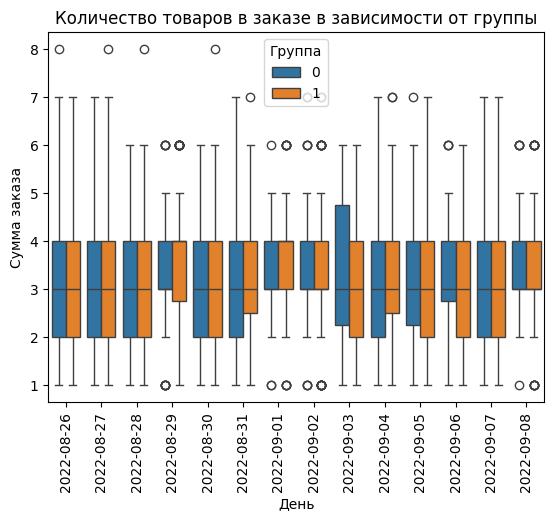

In [150]:
sns.boxplot(x = 'date', y = 'count_product', hue = 'group', data = df)
plt.title('Количество товаров в заказе в зависимости от дня')
plt.xlabel('День')
plt.ylabel('Сумма заказа')
plt.legend(title = 'Группа')
plt.xticks(rotation=90)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(array([-250.,    0.,  250.,  500.,  750., 1000., 1250., 1500., 1750.,
        2000.]),
 [Text(-250.0, 0, '−250'),
  Text(0.0, 0, '0'),
  Text(250.0, 0, '250'),
  Text(500.0, 0, '500'),
  Text(750.0, 0, '750'),
  Text(1000.0, 0, '1000'),
  Text(1250.0, 0, '1250'),
  Text(1500.0, 0, '1500'),
  Text(1750.0, 0, '1750'),
  Text(2000.0, 0, '2000')])

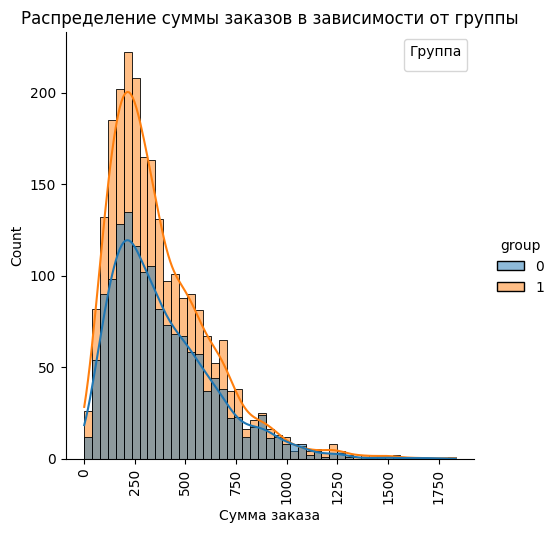

In [160]:
sns.displot(df, x = 'purchase_amount', hue='group', kde=True)
plt.title('Распределение суммы заказов в зависимости от группы')
plt.xlabel('Сумма заказа')
plt.legend(title = 'Группа')
plt.xticks(rotation=90)

In [164]:
df.head()

,user_id,order_id,action,time,date,group,creation_time,product_ids,count_product,purchase_amount,log_purchase_amount
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,"[75, 22, 53, 84]",4,408.7,6.012981
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,2022-08-26 00:02:21,"[56, 76, 39]",3,250.5,5.523459
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0,2022-08-26 00:02:27,"[76, 34, 41, 38]",4,310.2,5.737217
3,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1,2022-08-26 00:03:37,"[20, 45, 67, 26]",4,228.0,5.429346
4,968,1261,create_order,2022-08-26 00:05:35,2022-08-26,0,2022-08-26 00:05:35,"[30, 35, 69, 6]",4,430.7,6.065412


In [163]:
df["log_purchase_amount"] = np.log(df.purchase_amount)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(-1.0, 0, '−1'),
  Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5'),
  Text(6.0, 0, '6'),
  Text(7.0, 0, '7'),
  Text(8.0, 0, '8')])

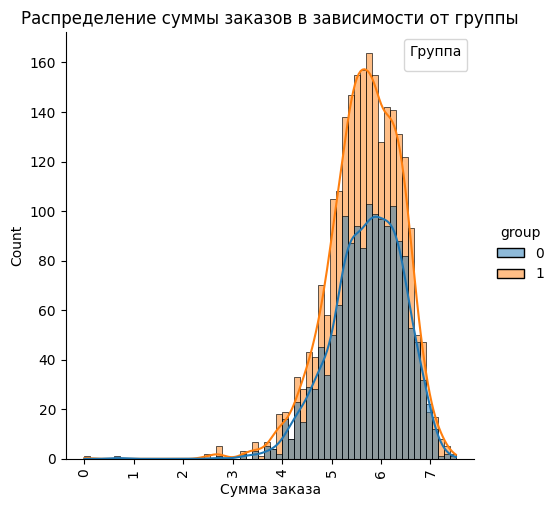

In [165]:
sns.displot(df, x = 'log_purchase_amount', hue='group', kde=True)
plt.title('Распределение логасуммы заказов в зависимости от группы')
plt.xlabel('Сумма заказа')
plt.legend(title = 'Группа')
plt.xticks(rotation=90)

In [166]:
pg.normality(df.query("group == 0"), method='normaltest').round(3)

,W,pval,normal
user_id,1711.466,0.0,False
order_id,213.980,0.0,False
group,NaN,NaN,False
count_product,36.288,0.0,False
purchase_amount,276.040,0.0,False
log_purchase_amount,150.782,0.0,False


In [167]:
pg.normality(df.query("group == 1"), method='normaltest').round(3)

/Users/any_empty/Library/Python/3.11/lib/python/site-packages/scipy/stats/_stats_py.py:1580: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/any_empty/Library/Python/3.11/lib/python/site-packages/scipy/stats/_stats_py.py:1776: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = kurtosis(a, axis, fisher=False)


,W,pval,normal
user_id,1346.271,0.0,False
order_id,277.986,0.0,False
group,NaN,NaN,False
count_product,42.202,0.0,False
purchase_amount,586.948,0.0,False
log_purchase_amount,294.576,0.0,False


### Выводы (из построенных графиков):
1. Распределения не являются нормальными

**Необходимо проводить bootstrap**

Стоимость заказа

In [171]:
group_1 = df.query("group == 1").purchase_amount
group_0 = df.query("group == 0").purchase_amount

In [172]:
ss.bootstrap((group_0, ), statistic=np.median)

BootstrapResult(confidence_interval=ConfidenceInterval(low=310.4, high=339.6), bootstrap_distribution=array([320. , 323.4, 323.4, ..., 314. , 325.5, 320. ]), standard_error=6.930873355782952)

In [173]:
ss.bootstrap((group_1, ), statistic=np.median)

BootstrapResult(confidence_interval=ConfidenceInterval(low=295.0, high=318.8), bootstrap_distribution=array([310.2 , 305.3 , 313.  , ..., 298.4 , 284.25, 297.25]), standard_error=6.035137681477745)

Количество продуктов в заказе

In [177]:
group_1_2 = df.query("group == 1").count_product
group_0_2 = df.query("group == 0").count_product

In [185]:
ss.bootstrap((group_0_2, ), statistic=np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=3.278323510150622, high=3.4053700065487886), bootstrap_distribution=array([3.35036018, 3.297315  , 3.33071382, ..., 3.32678454, 3.31761624,
       3.32940406]), standard_error=0.0328320419233339)

In [184]:
ss.bootstrap((group_1_2, ), statistic=np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=3.297229219143577, high=3.40176322418136), bootstrap_distribution=array([3.35474391, 3.40512175, 3.34214945, ..., 3.32829555, 3.35348447,
       3.3627204 ]), standard_error=0.026614893704765788)

### Вывод
Статистический анализ показал, что мы принимаем нулевую гипотезу, т.е. с высокой долей уверенности можем говорить о том, что среднее значение числа продуктов в заказе и стоимости заказа в экспериментальной и контрольной группах не различаются.